The source code for this project could be found [here](https://github.com/Xianzhiwang1/ml-0451-final-proj). We have a `README.md` file that outlines what our project want to achieve, and roughly how we are going to implement the models and analysis. We also have a separate `.txt` file that gives a dictionary of all the variable names and their actual meaning. Hence, we encourage the reader to also reference that `.txt` file to remember which variable means what.



# Introduction

- What is incorporation and why it matters
Incorporation is the process by which a firm becomes a corporation.

- What is the history of incorporation like

- Some historical context about Russia and descriptions about the Russians system of incorporation
Russia followed the concession system of incorporation.


## Data
- Where the data comes from

The Russian factory censuses from 1894, 1900 and 1908

- What the data includes

The data is factory level and includes the following information:


- What we're hoping to do with the data
- Some summary statistics


First, let us import some libraries that will become useful down the road. Also, the following snippet will automatically reload the `final_project_code.py` file where we keep our functions.  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from final_project_code import FinalProject 

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from matplotlib.patches import Patch
import seaborn as sns
from mlxtend.plotting import plot_decision_regions

In [5]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Read in the data
Let us create an instance of the class we defined in `final_project_code.py`, and let us read in the entire data set.

In [6]:
FP = FinalProject()

In [7]:
Rvss = pd.read_csv("./AG_Corp_Prod_DataBase.csv")

/tmp/ipykernel_23326/139095848.py:1: DtypeWarning: Columns (3,13) have mixed types. Specify dtype option on import or set low_memory=False.
  Rvss = pd.read_csv("./AG_Corp_Prod_DataBase.csv")


First, let's do some data visualization. We are interested in seeing which industry in Late Imperial Russia had high machine power (measured in horsepower) and have high number of workers. We also want to get a sense of the distribution of machine power and number of workers, and visualize them by industry. Hence, let's focus on the picture below. We see that roughly, factory with more machine power tend to also have more workers, and most company cluster at the $2000$ horse power level, and $2500$ workers.   

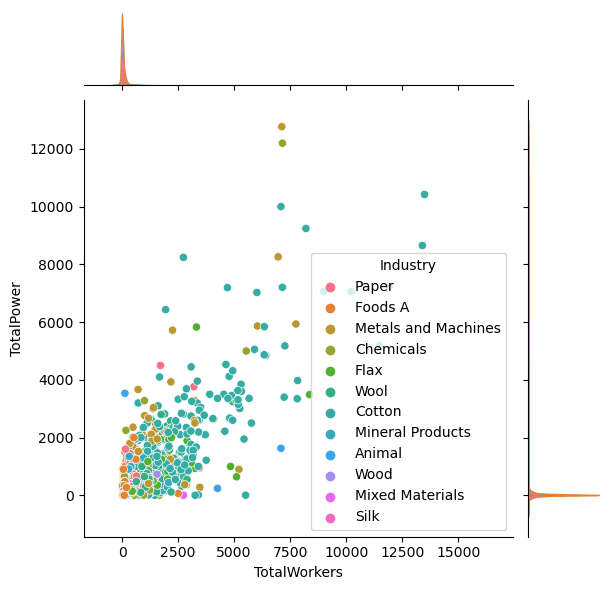

In [8]:
sns.jointplot(data=Rvss, x="TotalWorkers", y = "TotalPower", hue="Industry")

Similarly, here's another plot to visualize the unbalanced nature of the data set. Here, `Form` is the desired label that we want to predict. `Form` taking a value of $1$ means that factory was incorporated, i.e., it was owned by a incorporated firm. If `Form` take the value of $0$, then that factory was not incorporated. In the next plot, instead of `TotalPower`, which stands for Total amount of horse power and `TotalWorkers`, which stands for total number of workers, we use `logPowerperWorker` and `logRevperWorker` as our y-axis and our x-axis. `logPowerperWorker` is obtained by taking the log of $\frac{Power}{Worker}$, and `logRevperWorker` is log of $\frac{Revenue}{Worker}$. And the hue is whether the factory is encorporated or not. Again, we see that the orange dots, which corresponds to $1$, which corresponds to encorporated, is a very small percentage of all the factories. Most factories are not encorporated. Also, we observe that the data points follows a bell-shaped distribution on the two dimensions.  

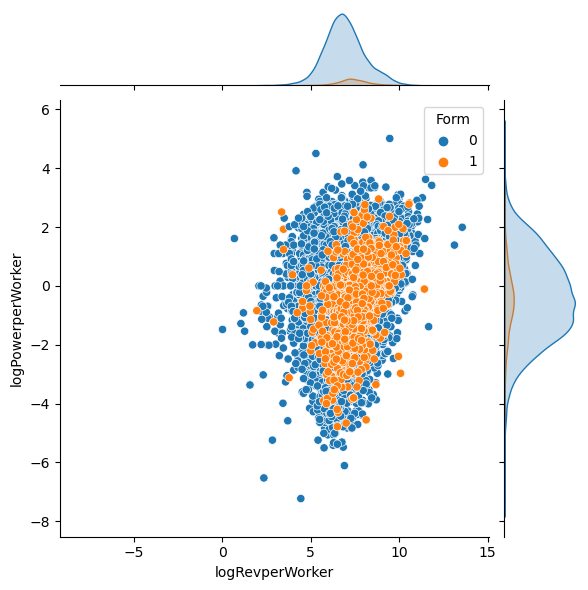

In [9]:
sns.jointplot(data=Rvss, x="logRevperWorker", y="logPowerperWorker", hue = "Form")

### Predicting whether Russian Factories want to incorporate or not
### First approach, rebalance the data set by random sampling
We start our analysis by using logistic regression to predict what kind of firms in late Imperial Russia is more likely owned by a corporation. Since our data is not balanced, we use several different approach to this problem and try them one at a time. Luckily for us, classification problem with unbalanced data labels is quite common, so we have many approaches at our disposal. 

Let us first get out definitions straight. Unbalanced data refers to those datasets where the target label has an uneven distribution of observations, 
 First, we try to randomly sample the majority data set, which in this case, is when the label equals unincorporated. Then we keep all the data entries of the minority data set, and add in the randomly sampled extract of the majority data set with size equal to the minority data set. Then we perform logistic regression on this new data set. The good news is that our new data set is balanced, and the bad news is that we loose a lot of information by discarding many data entries in the majority data set.  

Whether to incorporate or not is an interesting question for factories and firms in late Imperial Russia. There were many factors that might affect a firm's decision to incorporate or not, including the overall size of the factory, which could be seen in features such as total machine power of the factory and the total number of workers in a factory. Other factors such as the geographical location of the factory (i.e. which region it was located in) could also play a role. Since the decision to incorporate could be affected by many features, we see that some *feature engineering* could be beneficial for our analysis. 

We download the replication data set and put it in the same directory as our project. After we read in the data, we notice that there are $66$ columns, which means potentially we could have around $60$ features for our machine learning model. However, let's start small. Hence, we begin our analysis using a subset of the columns. Also, since in the original data set, there's only a small percentage of factories that are incorporated, which is because of historical reasons in Late Imperial Russia during 1894 to 1908. For the purpose of this machine learning project, we artificially select a subset of the whole data set so that we have equal number of factories owned by incorporated firms and not incorporated firms alike.

In [10]:
Rvss.loc[Rvss['Form']==0]

,Unnamed: 0,id,Form,PSZ,PSZ1900,FoundingYear,Province,Region,Industry,OntheSide,...,Animal,Wool,Cotton,MixedMaterials,Wood,Paper,MetalsandMachines,Foods,Chemical,Mineral
0,0,4156,0,NaN,NaN,1860.0,30,CentralIndustrial,Paper,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,52010,0,NaN,NaN,NaN,51,Previslitskii,Foods A,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2,30937,0,NaN,NaN,NaN,41,CentralBlacksoil,Foods A,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,39923,0,NaN,NaN,NaN,3,Caucasus,Metals and Machines,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4,3296,0,NaN,NaN,1882.0,11,Northwestern,Chemicals,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37964,37964,34420,0,NaN,NaN,NaN,30,CentralIndustrial,Mineral Products,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37965,37965,34210,0,NaN,NaN,NaN,19,CentralIndustrial,Mineral Products,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
37966,37966,52603,0,NaN,NaN,NaN,17,Southern,Foods A,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
37967,37967,4886,0,NaN,NaN,NaN,61,CentralIndustrial,Mineral Products,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
df = Rvss[['id', 'Form', 'FoundingYear',
       'Province', 'Region', 'Industry', 'OntheSide', 'Age', 'TaxedActivity',
       'YEAR', 'SubindustryCode', 'STCAP', 'Revenue',
       'TotalWorkers', 'TotalPower', 'GrandTotalWorkers', 'RevperWorker',
       'PowerperWorker', 'RevperGrandWorker', 'PowerperGrandWorker',
       'logRevperWorker', 'logPowerperWorker', 'logRevperGrandWorker',
       'logPowerperGrandWorker', 'logRev', 'logWorkers', 'logPower',
       'RegIndGroup', 'RegIndYearGroup', 'ProvIndGroup', 'ProvIndYearGroup',
       'IndYearGroup', 'IndustryFactor', 'ProvinceFactor', 'YearFactor',
       'AKTS', 'PAI', 'factory_id', 'FormNextYear', 'FormNextNextYear',
       'FactoryisCorpin1894', 'FormNextYearin1894', 'FactoryisCorpin1900',
       'FormNextYearin1900', 'FactoryisCorpin1908', 'NEWDEV', 'SHARES',
       'STPRICE', 'BONDS', 'Silk', 'Flax', 'Animal', 'Wool', 'Cotton',
       'MixedMaterials', 'Wood', 'Paper', 'MetalsandMachines', 'Foods',
       'Chemical', 'Mineral']]

In [12]:
result = FP.create_balanced_data(df)

df incorporated have 2393 many rows
after balancing, df not incorporated have 2393 many rows


In [13]:
result['Form'].mean()

0.5

In [14]:
compression_opts = dict(method='zip', archive_name='artificially_balanced_Rvssian_Factory.csv')
result.to_csv('artificially_balanced_Rvssian_Factory.zip', index = False, compression=compression_opts)

In [15]:
FP = FinalProject()
train, validate, test = FP.split_data(result)

In [16]:
df_train, X_train, y_train = FP.prepare_data(train)
df_validate, X_validate, y_validate= FP.prepare_data(validate)
df_test, X_test, y_test = FP.prepare_data(test)

# Let's do some visualization

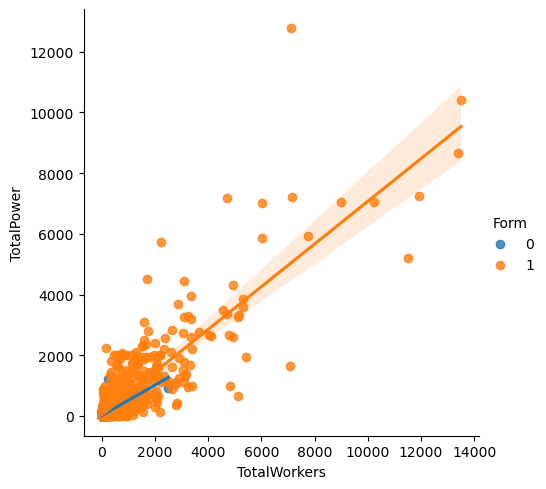

In [17]:
sns.lmplot(data=df_train, x="TotalWorkers", y = "TotalPower", hue="Form")

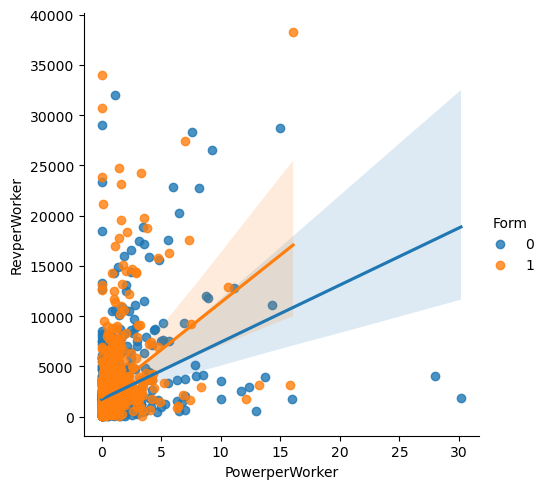

In [18]:
sns.lmplot(data=df_train, x="PowerperWorker", y = "RevperWorker", hue="Form")

# First, we try some feature engineering
In the basic toolbox of an economist, one is unlikely to find methods of feature engineering, since we believe that economists would rather choose the regressors (features) themselves, becuase regressors are often central to the economic questoin and analysis. However, in this project, we actually going to have a systematic way written in code to select the features, according to which combination of features gives the highest score.

In [19]:
X_train, RegionCoded =   FP.encode_features(X_train, "Region")
X_train['RegionCoded'] = RegionCoded

In [20]:
X_train, IndustryCoded = FP.encode_features(X_train, "Industry")
X_train["IndustryCoded"] = IndustryCoded
X_train = X_train.fillna(0)
# X_train.head(10)

In [21]:
X_train, IndustryFactorCoded = FP.encode_features(X_train, 'IndustryFactor')
X_train["IndustryFactorCoded"] = IndustryFactorCoded

In [30]:
FP1 = FinalProject() 
all_qual_cols = ['RegionCoded', 'IndustryCoded', "IndustryFactorCoded"] 

all_quant_cols = [
       'Province', 'OntheSide', 'Age', 'TaxedActivity',
       'YEAR', 'SubindustryCode', 'STCAP', 'Revenue',
       'TotalWorkers', 'TotalPower', 'GrandTotalWorkers', 'RevperWorker',
       'PowerperWorker', 'RevperGrandWorker', 'PowerperGrandWorker',
       'logRevperWorker', 'logPowerperWorker', 'logRevperGrandWorker',
       'logPowerperGrandWorker', 'logRev', 'logWorkers', 'logPower',
       'RegIndGroup', 'RegIndYearGroup', 'ProvIndGroup', 'ProvIndYearGroup',
       'IndYearGroup', 'ProvinceFactor', 'YearFactor',
       'AKTS', 'PAI', 'factory_id', 'FormNextYear', 'FormNextNextYear',
       'FactoryisCorpin1894', 'FormNextYearin1894', 'FactoryisCorpin1900',
       'FormNextYearin1900', 'FactoryisCorpin1908', 'NEWDEV', 'SHARES',
       'STPRICE', 'BONDS', 'Silk', 'Flax', 'Animal', 'Wool', 'Cotton',
       'MixedMaterials', 'Wood', 'Paper', 'MetalsandMachines', 'Foods',
       'Chemical', 'Mineral']
y_train = y_train.reset_index(drop=True)
FP1.feature_combo(all_qual_cols, all_quant_cols, X_train, y_train)    

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

In [31]:
max(FP1.feature_score_pair, key=FP1.feature_score_pair.get)

('RegionCoded', 'FactoryisCorpin1900', 'NEWDEV')

Hence, for fitting logistic regression on the training data, the highest scoring combination of 3 features among the independent variables that we considered is `RegionCoded`, `RevperGrandWorker`, `logWorkers`. 

In [33]:
# test for max 
max([-10, 5, 3], key=abs)
print(max(FP1.feature_score_pair.values()))
print(FP1.feature_score_pair[('RegionCoded', 'RevperGrandWorker', 'logWorkers')])
print(FP1.feature_score_pair[("RegionCoded", "FactoryisCorpin1900", "NEWDEV")])

0.9944270289097875
0.8025078369905956
0.9944270289097875


### The Prediction Question:
Can we predict which factory belongs to a incorporated company in Late Imerial Russia, during year 1894 and year 1908, by looking at other variables that are in the data? 

### Data Inspection
Since previously we have artificially selected a subset of our entire Russian factory data set so that we have equal number of factories belonging to incorporated firms and not incorporated firms, we expect that our label has roughly $50 \%$ of $1$'s and $50 \%$ % of $0$'s.

In [34]:
y_train.mean()

0.5019157088122606

In [35]:
df_train.groupby(['Industry'])[['Form']].aggregate([np.mean, len]).round(3)

Form     
                      mean  len
Industry                       
Animal               0.205  190
Chemicals            0.737  190
Cotton               0.827  346
Flax                 0.663   92
Foods A              0.274  482
Metals and Machines  0.627  515
Mineral Products     0.429  280
Mixed Materials      0.354   65
Paper                0.505  218
Silk                 0.354   48
Wood                 0.414  232
Wool                 0.441  213

Hence, it seems that Food industry in Late Imperial Russia had a low incorporation rate, which is around $28.3 \%$. On the other hand, the Cotton industry had a relatively high incorporation rate, around $81.4 \%$.

In [36]:
df_train.groupby(['Industry'])[['TotalPower']].aggregate([np.mean, len]).round(3)

TotalPower     
                          mean  len
Industry                           
Animal                  41.061  190
Chemicals              280.530  190
Cotton                1283.686  346
Flax                   534.179   92
Foods A                 72.457  482
Metals and Machines    255.735  515
Mineral Products        57.301  280
Mixed Materials         78.791   65
Paper                  165.861  218
Silk                    41.906   48
Wood                    66.531  232
Wool                   194.150  213

We see that Cotton industry has the highest mean total power, and Silk industry has the lowest mean total power. We might predict that industry with a higher need for capital might choose to incorporate. 
### After doing feature engineering, we perform a standard regression analysis using the combination of features with the highest scores.
### Running some logistic regressions and plotting ROC curves
We start with the standard procedure in Econometrics, which is running regressions. We first perform some regression analysis that is close in spirit to the published paper where this replication data set is coming from, and use ROC curve and confusion matrix to assess our model performance. First, let's get our definition straight. 

* `True Positive Rate = True Positives / (True Positives + False Negatives)`
* `False Positive Rate = False Positives / (False Positives + True Negatives)`

The ROC curve is especially useful when we want to compare directly the curve of several different models. Also, AUC, which stands for the area under the curve can be used to measure how good a model is. 



In [107]:

important_cols = ['RegionCoded', 'RevperGrandWorker', 'logWorkers']
high_scoring_cols = ["RegionCoded", "FactoryisCorpin1900", "NEWDEV"]
# X_train = X_train.dropna()
# X_train = X_train.drop(["Industry"], axis=1)
# X_train = X_train.drop(["Region"], axis=1)
# X_train.drop(["FoundingYear", "OntheSide", "TaxedActivity", "PSZLastYear", "PSZ1908"], axis=1)
X_train = X_train.fillna(0)
y_train.reset_index(drop=True)

# cols = ["FactoryisCorpin1900", "NEWDEV"]
cols = ['RevperGrandWorker', 'logWorkers']
# fit a model
LR = LogisticRegression(solver="newton-cg") # Newton's Method
LR.fit(X_train[cols], y_train)
LR.score(X_train[cols], y_train)

0.8021595262974573

In [108]:
X_test = X_test.fillna(0)

In [109]:
# ROC curve, receiver operating characteristic
# TPR true positive rate
# FPR false positive rate

# predict the probability
probability = LR.predict_proba(X_test[cols])

In [110]:
# get the probabilities for the positive outcome
proba_positive = probability[:,1]

In [111]:
# get a no-skill prediction that always predict the majority class
proba_no_skill = [0 for _ in range(len(y_test))]

In [120]:
# compute the scores
auc_no_skill = roc_auc_score(y_test, proba_no_skill) 
auc_LR = roc_auc_score(y_test, proba_positive)
print(f"Always predict zero, which is not incorporate. ROC AUC = {auc_no_skill}")
print(f"Use Logistic Regression. ROC AUC = {auc_LR}")
# fpr, tpr, thresholds = roc_curve(y_train, scores, pos_label=2)

Always predict zero, which is not incorporate. ROC AUC = 0.5
Use Logistic Regression. ROC AUC = 0.8655317145883183


[[0.78197065 0.21802935]
 [0.22037422 0.77962578]]


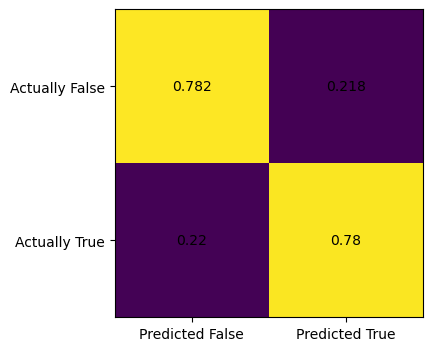

In [129]:
print(confusion_matrix(y_test, LR.predict(X_test[cols]), normalize="true"))
FP.print_confusion_matrix(LR, X_test[cols], y_test)

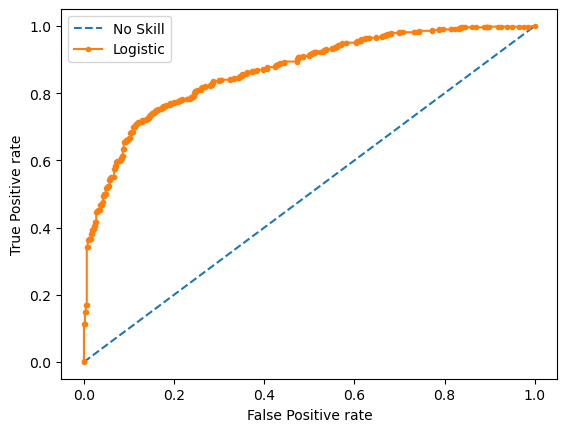

In [79]:
# compute roc curves
fpr_no_skill, tpr_no_skil, _ = roc_curve(y_test, proba_no_skill)
fpr_LR, tpr_LR, _ = roc_curve(y_test, proba_positive)
# plot the roc curve for the model
plt.plot(fpr_no_skill, tpr_no_skil, linestyle="--", label="No Skill")
plt.plot(fpr_LR, tpr_LR, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
# show the legend
plt.legend()
# show the plot
plt.show()



We are interested in seeing the coefficients for the regressors in our logistic regression. We see that the coefficient for revenue per worker grand total `RevperGrandWorker` is $0.000056$, and the coefficient for `logWorkers`, the log of the number of workers is $1.048$. In the cells below, we are also interested in visualizing the decision region of our model. We see that the desion boundary is linear, and since our data are all relatively clustered together, the picture does not really show that our model is doing a fantastic job. It is quite hard to guess how many data points are in the correct region because of it's quite dense. 

In [80]:
pd.DataFrame({
    "column": X_train[cols].columns,
    "coefficient": LR.coef_.ravel()
})

,column,coefficient
0,RevperGrandWorker,0.000056
1,logWorkers,1.048007


In [71]:
type(X_train[cols])
col=['TotalWorkers','TotalPower']
# X_test[col].head(50)

False


/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


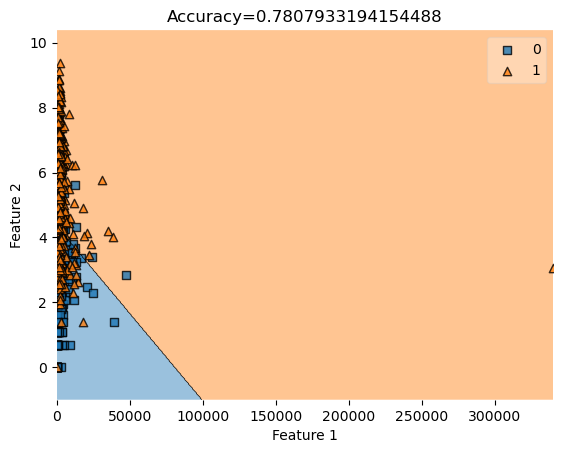

In [82]:
print(isinstance(X_train[cols], np.ndarray))
# need to write up the function that make a visual representation
value=1.5
width=0.75
plot_decision_regions(X_test[cols].to_numpy(), y_test.to_numpy(), clf=LR
                    #   filler_feature_values={2:value},
                    #   filler_feature_ranges={2:width}
                      )
mypredict = LR.predict(X_test[cols].to_numpy())
title = plt.gca().set(title=f"Accuracy={(mypredict==y_test).mean()}",
                      xlabel="Feature 1",
                      ylabel="Feature 2")

### Now we try Polynomial Features
### Use cross validation

In [22]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

Now, we are unsure if using polynomial features would give our model more predictive power. One way to find out is by trying different degrees of polynomials and score them using cross validation. The idea behind cross validation is as follows: we divide the data into little chunks, and in each regression, one of the chunks is used as validation data set, and all other chunks are used as training data set. Each little chunk takes turn to be used for validation, hence the name cross validation. We could take the average of all those scores and use this average to compare models with different degrees. 

In [23]:
def poly_LR(deg):
    return Pipeline([("poly", PolynomialFeatures(degree=deg)),
                     ("LR", LogisticRegression(penalty="none", max_iter=int(1e3)))])

plr = poly_LR(deg = 2)

In [24]:
cv_scores = cross_val_score(plr, X_train[cols], y_train, cv=5)
cv_scores

NameError: name 'cols' is not defined

In [25]:
cv_scores.mean()

NameError: name 'cv_scores' is not defined

Hence, this is telling us that for the features we selected, polynomial logistic regression has roughly the same predictive power as simply guessing whether a factory is belonging to a corporation or not. Degree zero corresponds to the baseline model, and degree 1 corresponds to simple logistic regression without a polynomial feature map.

In the above code snippets, we defined a model using degree 2 polynomial features, did cross validation by dividing data into 5 chunks, and then we take the mean to get the final score. Now, we put this into a function with a for loop, that will lop through each 

In [26]:
FP.polynomial_degree_validation(X_train[cols], y_train, 4, 5)

NameError: name 'cols' is not defined

Hence, we see that degree one has the highest score, meaning that we just need simple logistic regression in this case. Since this score comes from cross validation, we could rely on the accuracy of this score to some extent. Now, we use simple logistic regression with no polynomial features to `fit` our training data once again, and we test on the testing data. 

In [27]:
plr = poly_LR(1)
plr.fit(X_train[cols], y_train)
plr.score(X_train[cols], y_train)
X_test = X_test.fillna(0)
plr.score(X_test[cols], y_test).round(4)

NameError: name 'cols' is not defined

We get a score of $0.78$, which is not bad! Also, let us print out the classification report for our model. Again, our precision score is not bad!

In [28]:
y_predict = plr.predict(X_test[cols])
print(classification_report(y_test, y_predict))

NameError: name 'cols' is not defined

In [29]:
print(confusion_matrix(y_test, y_predict))
print(confusion_matrix(y_test, y_predict, normalize = "true"))

NameError: name 'y_predict' is not defined

Recall that the confusion matrix is organized as follows, so we could read the data right off the matrix.
$$ 
\begin{matrix}
\text{True Positive} & \text{False Positive} \\
\text{False Negative} & \text{True Negative} \\
\end{matrix}
$$
In our case, we have $373$ true positives and $375$ true negatives for our test data, and $104$ false positives and $106$ false negatives. This is quite evenly distributed, our model does not give more false positives than false negatives or the other way round. Hence, our model's prediction is not biased towards positive or negative. Also, by specifying `normalize = "true"`, we could get the True Positive Rate (TPR), False Positive Rate (FPR), and so on. Feel free to check the definition given above earlier. 

Now, let's find out the mean machine power per worker for our testing set `X_test`, which is $0.6991$. Now, we would like to filter our test data `X_test` and only keep the entries that have more than average power per worker. Then we print out our compusion matrix again just for those entries with more than average machine power per worker. We are interested to see if our model is biased or not, in the sense that it might give more False Positives than False Negatives, or the other way round.

In [30]:
X_test["PowerperWorker"].mean()

1.0800762835955882

In [31]:
ix = X_test["PowerperWorker"] > 0.63483127
print("Factories with more power per worker than average")
print(f"The percentage our prediction is correct: {(y_test[ix] == y_predict[ix]).mean()}")
confusion_matrix(y_test[ix], y_predict[ix])

Factories with more power per worker than average


NameError: name 'y_predict' is not defined

We see that our model has predicted false negative for $24$ cases, and false positive for $17$ cases for factories with more power per worker than average. Hence, in this case, our model is slightly biased towards false negative, predicting the factory is not incorporated (negative) when the factory is actually incorporated (positive). This makes economic sense, since we have selected only factories with above average machine power, and since factories with more machine power stood to gain more investment and capital if they incorporate, they were more likely to incorporate than average, so our model, which is trained on all the entries in `X_train`, has predicted more false negatives for factories with more power, and this fits our economic intuition.

In [32]:

ix = X_test["PowerperWorker"] < 0.63483127
print("Factories with less power per worker than average")
print(f"The percentage our prediction matches the actual label: {(y_test[ix] == y_predict[ix]).mean()}")
print(confusion_matrix(y_test[ix], y_predict[ix]))
print(confusion_matrix(y_test[ix], y_predict[ix], normalize="true"))

Factories with less power per worker than average


NameError: name 'y_predict' is not defined

We do the exact same thing for restricting our data set to only factories with less machine power per worker than average. The situation is exactly flipped, since we have more false positive than false negative. Our model tend to predict incorporated when the factory was not incorporated. This is consistent with our findings earlier, since we are in the exact flip case, where we restrict to factories with less machine power, and those are factories that potentially benefit less from the access to more captial and credit brought by incorporation, since they are not perticularly machine intensive. Hence, they had a slightly lower probability to incorporate. 

# Logistic regression implementing Newton's Method

In [105]:
cols = ['PowerperWorker', 'RevperGrandWorker']
cols=['TotalWorkers','TotalPower']
cols = ['logWorkers', 'logPower']
X_train = X_train.fillna(0)
print(X_train[cols].shape)
beta_old = np.ones((X_train[cols].shape[1],1))
print(beta_old.shape)

(2871, 2)
(2, 1)


In [93]:
# y_train = y_train.to_numpy()
y_train = y_train.reshape(-1,1)
print(y_train.shape)

(2871, 1)


# Moment of Truth

In [106]:
FP.regress(y_train, X_train[cols], beta_old )

In [107]:
FP.beta

array([[   1.38095048,  -18.13745557,    1.38095048, ...,    1.38095048,
         -18.13745557,    1.38095048],
       [   1.17353846, -202.70596159,    1.17353846, ...,    1.17353846,
        -202.70596159,    1.17353846]])

In [96]:
Reg = LogisticRegression(tol = 0.01, solver='newton-cg').fit(X_train[cols], y_train)

/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [97]:
print(f"the coefficients are: {Reg.coef_}")
print(f"the intercept is: {Reg.intercept_}")

the coefficients are: [[1.05885484 0.08455992]]
the intercept is: [-4.5901754]


In [98]:
print(X_test[cols].to_numpy().shape)
print(FP.predict(X_test[cols].to_numpy()).shape)

(958, 2)
(958, 1)


In [108]:
y_train = y_train.reshape(-1)
plot_decision_regions(X_train[cols].to_numpy(), y_train, clf=FP
                    #   filler_feature_values={2:value},
                    #   filler_feature_ranges={2:width}
                      )
mypredict = FP.predict(X_train[cols].to_numpy())
title = plt.gca().set(title=f"Accuracy={(mypredict==y_train).mean()}",
                      xlabel="Feature 1",
                      ylabel="Feature 2")

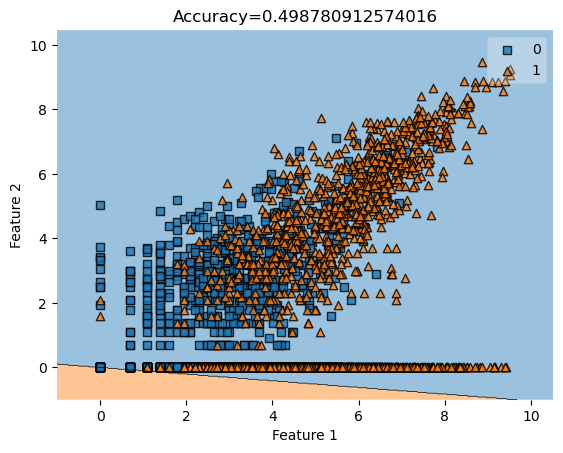

In [99]:
y_train = y_train.reshape(-1)
plot_decision_regions(X_train[cols].to_numpy(), y_train, clf=FP
                    #   filler_feature_values={2:value},
                    #   filler_feature_ranges={2:width}
                      )
mypredict = FP.predict(X_train[cols].to_numpy())
title = plt.gca().set(title=f"Accuracy={(mypredict==y_train).mean()}",
                      xlabel="Feature 1",
                      ylabel="Feature 2")

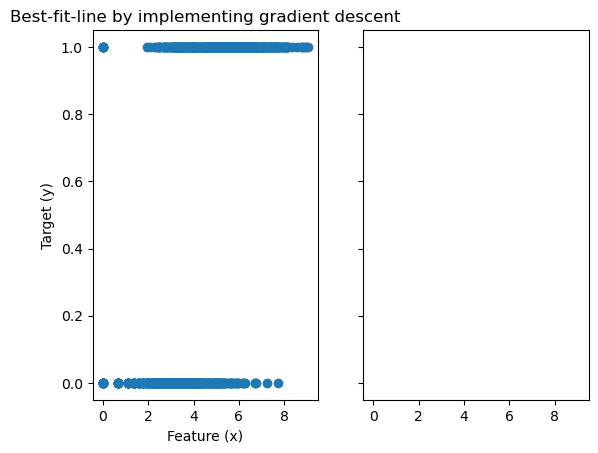

In [100]:

# gradient

x = X_test[cols].to_numpy()[:,0]
fig, axarr = plt.subplots(1, 2, sharex = True, sharey = True)
axarr[0].scatter(X_test[cols].to_numpy()[:,0], y_test.to_numpy())
# axarr[0].plot(x, x@FP.beta, color = "black")

# Analytic 
# LR2 = LinearRegression()
# X_ = LR2.pad(x)
# LR2.fit_analytic(X_,y)

# axarr[1].scatter(x,y)
# axarr[1].plot(x, X_@LR2.w, color = "black")

labs = axarr[0].set(title="Best-fit-line by implementing gradient descent", xlabel = "Feature (x)", ylabel = "Target (y)")


In [101]:
print(isinstance(X_test[cols], np.ndarray))
X_test = X_test.fillna(0)

False


/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/xianzhiwang/miniforge3/envs/ml-0451/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


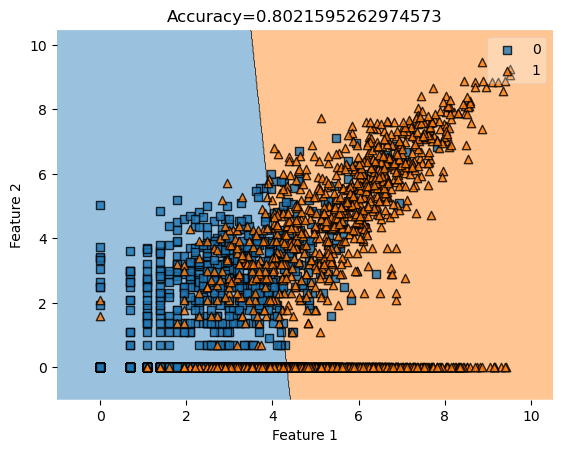

In [102]:
value=1.5
width=0.75
plot_decision_regions(X_train[cols].to_numpy(), y_train, clf=Reg
                    #   filler_feature_values={2:value},
                    #   filler_feature_ranges={2:width}
                      )
mypredict = Reg.predict(X_train[cols].to_numpy())
title = plt.gca().set(title=f"Accuracy={(mypredict==y_train).mean()}",
                      xlabel="Feature 1",
                      ylabel="Feature 2")